In [16]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [18]:
bp = '/home/storage/hans/jax_reco_new/examples/'

first_pulse = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_altrho_1st_pulse.npy')), 
                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_altrho_1st_pulse.npy'))])

#five_pulses = np.concatenate([np.load(os.path.join(bp, 'reco_result_21217_tfrecord_n_pulses5_altrho.npy')), 
#                             np.load(os.path.join(bp, 'reco_result_21220_tfrecord_n_pulses5_altrho.npy'))])

print(len(first_pulse))

202092


In [19]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [20]:
def get_gcd(results):
    scale = 20.0
    reco_zenith, reco_azimuth = results[:, -5]/scale, results[:, -4]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [21]:
gcd, gcd_smpe, muon_energy = get_gcd(first_pulse)

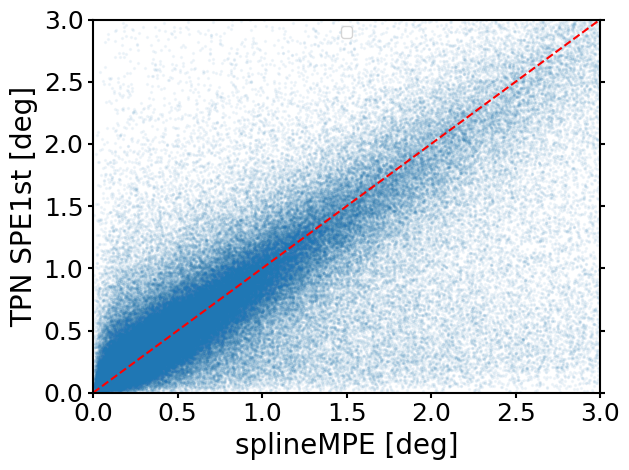

In [22]:
fig, ax = plt.subplots()
plt.scatter(gcd_smpe, gcd, s=2, alpha=0.05)
plt.xlim([0.0, 3.0])
plt.ylim([0.0, 3.0])
plt.plot([0.0, 3.0], [0.0, 3.0], "r--")
plt.xlabel("spline_mpe [deg]")
plt.ylabel("tpn_spe1st [deg]")
plot_args = {'xlim':[0.0, 3.0],
              'ylim':[0.0, 3.0],
               'xlabel':'splineMPE [deg]',
                'ylabel':'TPN SPE1st [deg]'}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

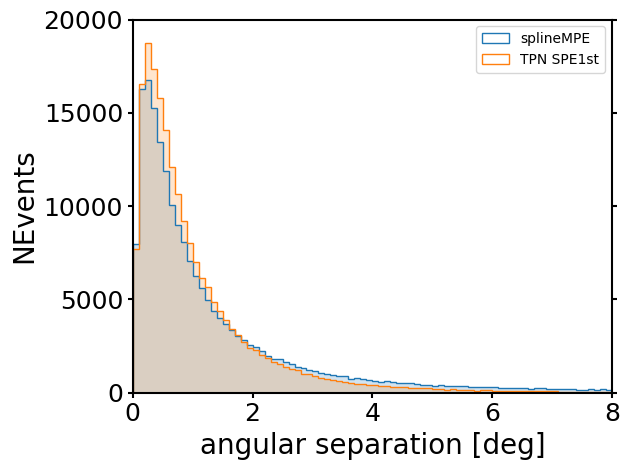

In [23]:
fig, ax = plt.subplots()
bins = np.linspace(0.0, 8.0, 81)
ax.hist(gcd_smpe, bins=bins, histtype='step', color='tab:blue', label='splineMPE')
ax.hist(gcd_smpe, bins=bins, color='tab:blue', alpha=0.2)
ax.hist(gcd, bins=bins, histtype='step', color='tab:orange', label='TPN SPE1st')
ax.hist(gcd, bins=bins, color='tab:orange', alpha=0.2)
plot_args = {'xlim':[0.0, 8.0],
              'ylim':[0.0, 20000],
               'xlabel': 'angular separation [deg]',
                'ylabel':'NEvents'}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()

In [24]:
def get_quantiles(dpsi, energy, e_bins):
    lower, med, upper = [], [], []
    for el, eh in zip(e_bins[:-1], e_bins[1:]):
        #print(el, eh)
        idx = np.logical_and(energy >= el, energy < eh)
        l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
        lower.append(l)
        med.append(m)
        upper.append(u)
        
    return lower, med, upper

centers = lambda x: 0.5 * (x[:-1]+x[1:])

In [25]:
def make_eres_plot(gcd, gcd_smpe, muon_energy):
    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)
    fig, ax = plt.subplots()
    plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.0, 1.5]}
    
    #ax.plot(e_nu_centers, lower, color='red', label='20%', linestyle='dashed')
    ax.plot(10**e_nu_centers, med, color='red', label='TPN SPE1st')
    #ax.plot(e_nu_centers, upper, color='red', label='80%', linestyle='dotted')
    #ax.plot(e_nu_centers, lower2, color='cyan', label='20%', linestyle='dashed')
    ax.plot(10**e_nu_centers, med2, color='cyan', label='spline MPE')
    #ax.plot(e_nu_centers, upper2, color='cyan', label='80%', linestyle='dotted')
    adjust_plot_1d(fig, ax, plot_args=plot_args)
    plt.xscale('log')
    plt.title('median angular resolution')
    plt.show()

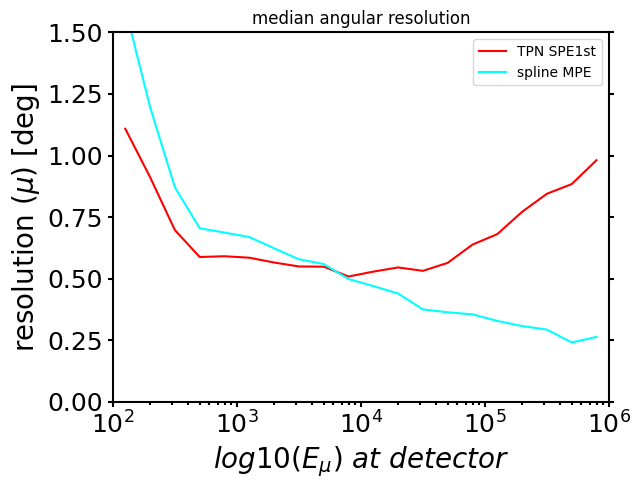

In [26]:
make_eres_plot(gcd, gcd_smpe, muon_energy)

In [11]:
print(muon_energy)

[1.74066948e+02 7.73978401e+02 3.86096186e+02 ... 1.38926580e+05
 7.30651263e+05 4.67469802e+05]


In [12]:
print(np.amin(muon_energy))

100.01408254484268


In [13]:
print(np.amax(muon_energy))

996063.9879405426


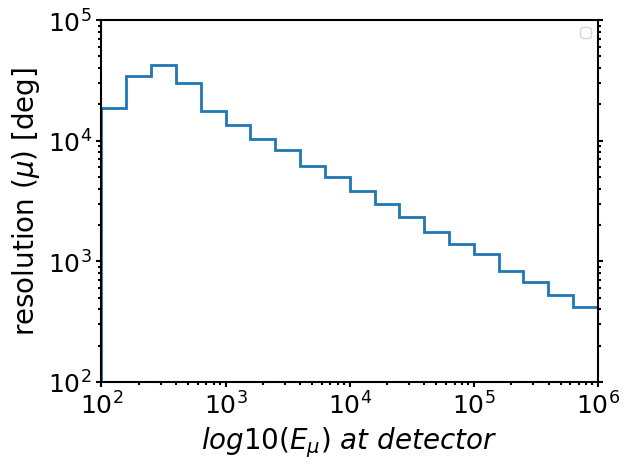

In [14]:
fig, ax = plt.subplots()
plt.hist(muon_energy, bins=np.logspace(2.0, 6.0, 21), histtype='step', color='tab:blue', lw=2)
plt.yscale('log')
plt.xscale('log')
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[10**2.0, 10**5]}
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.tight_layout()
plt.show()